In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import numpy as np
import pandas as pd
import random
from torch.nn import functional as F
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2
import torch.nn as nn

In [2]:
fh = open('research_fishes/summary.txt', 'r')
label_index = []
for index,line in enumerate(fh):
    label_index.append((line.split()[0],index))
label_indexs = dict(label_index)
label_indexs

{'fish_cod': 0,
 'fish_commondab': 1,
 'fish_greygurnard': 2,
 'fish_haddock': 3,
 'fish_hake': 4,
 'fish_horsemackerel': 5,
 'fish_longroughdab': 6,
 'fish_mackerel': 7,
 'fish_norwaypout': 8,
 'fish_plaice': 9,
 'fish_redgurnard': 10,
 'fish_saithe': 11,
 'fish_whiting': 12}

In [3]:
def generate_imgs_file(dir):
    import glob
    path_dic = []
    for index,value in enumerate(label_indexs.keys()):
        #print(type(i))
        paths = glob.glob(dir + "/*/"+ value +"/*.png")

        for path in paths:
            path_dic.append([path,index])
    
    path_dic = pd.DataFrame(path_dic,columns = ['path','label'])
    return path_dic

In [4]:
path_dic = generate_imgs_file('research_fishes')
print(path_dic.shape)
path_dic.head()

(9620, 2)


,path,label
0,research_fishes/fold_011/fish_cod/66488f15-aff...,0
1,research_fishes/fold_011/fish_cod/1fd0d098-70e...,0
2,research_fishes/fold_011/fish_cod/0fbd916b-ea0...,0
3,research_fishes/fold_011/fish_cod/1ee49e38-ec2...,0
4,research_fishes/fold_011/fish_cod/1ee49e38-ec2...,0


In [5]:
path_dic2 = generate_imgs_file('commercial_fishes')
print(path_dic2.shape)
path_dic2.head()

(10057, 2)


,path,label
0,commercial_fishes/fold_127/fish_cod/c3cc47ed-0...,0
1,commercial_fishes/fold_127/fish_cod/77e33edc-6...,0
2,commercial_fishes/fold_127/fish_cod/0158dd29-8...,0
3,commercial_fishes/fold_127/fish_cod/77e33edc-6...,0
4,commercial_fishes/fold_117/fish_cod/b19fca17-7...,0


In [6]:
train_transform = A.Compose(
    [
        A.Affine(translate_px={"x":(-2,2),"y":(-2,2)}, scale = (0.75,1.333), rotate = 180, p = 0.5),
        A.GaussNoise(var_limit = (10,100), p = 0.5),
        A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4,p=0.5),
        A.CoarseDropout(max_holes=1, max_height=90, max_width=90, min_holes=1,fill_value=64, p = 0.5),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        
        ToTensorV2()
    ],
)
val_transform = A.Compose(
    [
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ],
)

In [7]:
class MyDataset(Dataset): 
    def __init__(self, path_dic, transform=None):

        self.imgs = list(path_dic.to_records(index=False))
        self.transform = transform
        
    def __getitem__(self, index):
        path, label = self.imgs[index]
        
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            img = self.transform(image=img)["image"]

        return img,label
    
    def __len__(self):
        return len(self.imgs)

In [8]:
# val_sour_size = 2000
# num_sour_train = len(path_dic)
# sour_indices = list(range(num_sour_train))
# #split_ratio = 0.8
# #split = int(np.floor(train_size * num_train))
# np.random.shuffle(sour_indices)
# train_sour_idx, valid_sour_idx = sour_indices[val_sour_size:], sour_indices[:val_sour_size]
train_sour_idx = np.load('train_sour_idx.npy')
valid_sour_idx = np.load('valid_sour_idx.npy')

In [9]:
# val_targ_size = 2000
# num_targ_train = len(path_dic2)
# targ_indices = list(range(num_targ_train))
# #split_ratio = 0.8
# #split = int(np.floor(train_size * num_train))
# np.random.shuffle(targ_indices)
# train_targ_idx, valid_targ_idx = targ_indices[val_targ_size:], targ_indices[:val_targ_size]
train_targ_idx = np.load('train_targ_idx.npy')
valid_targ_idx = np.load('valid_targ_idx.npy')

In [10]:
source_data = MyDataset(path_dic, transform = train_transform)
source_data2 = MyDataset(path_dic, transform = val_transform)
target_data = MyDataset(path_dic2, transform = train_transform)
target_data2 = MyDataset(path_dic2, transform = val_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


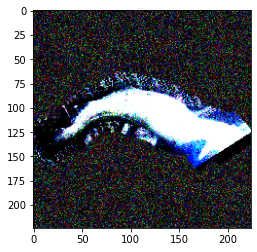

In [11]:
import matplotlib.pyplot as plt
plt.imshow(target_data[2][0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


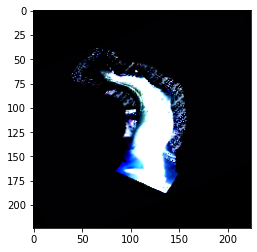

In [12]:
plt.imshow(target_data[2][0].permute(1, 2, 0))

In [11]:
sour_train_data = Subset(source_data, indices=train_sour_idx)
sour_val_data = Subset(source_data2, indices=valid_sour_idx)
targ_train_data = Subset(target_data, indices=train_targ_idx)
targ_val_data = Subset(target_data2, indices=valid_targ_idx)

In [13]:
len(sour_train_data)

7620

In [14]:
def getSampler(labels):
    class_sample_count = np.unique(labels, return_counts=True)[1]
    class_weights = 1./torch.tensor(class_sample_count, dtype=torch.float) 
    class_weights_all = class_weights[labels]
    sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
    )
    return sampler

In [15]:
sour_train_labels = []
for train_index in sour_train_data.indices:
    sour_train_labels.append(source_data.imgs[train_index][1])
sour_train_labels = torch.tensor(sour_train_labels)
sour_sampler = getSampler(sour_train_labels)

In [16]:
targ_train_labels = []
for train_index in targ_train_data.indices:
    targ_train_labels.append(target_data.imgs[train_index][1])
targ_train_labels = torch.tensor(targ_train_labels)
targ_sampler = getSampler(targ_train_labels)

In [17]:
sour_train_dl = DataLoader(sour_train_data, shuffle=False, batch_size=40, sampler=sour_sampler, num_workers = 4, pin_memory = True)
targ_train_dl = DataLoader(targ_train_data, shuffle=False, batch_size=40, sampler=targ_sampler, num_workers = 4, pin_memory = True)
sour_val_dl = DataLoader(sour_val_data, batch_size=64, num_workers = 4, pin_memory = True)
targ_val_dl = DataLoader(targ_val_data, batch_size=64, num_workers = 4, pin_memory = True)

In [19]:
# #check sampler
# subset_index = []
# for i, j in sour_train_dl:
#     subset_index = np.concatenate((subset_index, j.numpy()), axis=None)
# a = np.unique(subset_index, return_counts=True)
# a

In [18]:
student = torchvision.models.resnet152(pretrained=True)
student.fc = nn.Sequential(
            nn.Linear(2048,1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024,13)
)

In [19]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)
    

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
student = to_device(student, device)

In [22]:
sour_train_dl = DeviceDataLoader(sour_train_dl, device)
sour_val_dl = DeviceDataLoader(sour_val_dl, device)
targ_train_dl = DeviceDataLoader(targ_train_dl, device)
targ_val_dl = DeviceDataLoader(targ_val_dl, device)

In [23]:
@torch.no_grad()
def train_pred(X_sup):
    student.eval()
    #return F.softmax(student(X_sup), dim=1).detach().cpu().numpy()
    return student(X_sup)

@torch.no_grad()
def f_eval_src(val_dl,num):

    stu_num = 0
    for X_sup, y_sup in val_dl:

        y_pred_prob_stu = train_pred(X_sup)
        #y_pred_stu = np.argmax(y_pred_prob_stu, axis=1)
        _, y_pred_stu = torch.max(y_pred_prob_stu, dim=1)
        
        stu_num += torch.tensor(torch.sum(y_pred_stu != y_sup).item())
        #float((y_pred_stu != y_sup.cpu().numpy()).sum())
    return stu_num/num

In [44]:
# learning_rate = 0.001
# epochs = 30
# student_params = list(student.parameters())
# teacher_params = list(teacher.parameters())
# for param in teacher_params:
#     param.requires_grad = False

# student_optimizer = torch.optim.SGD(student.parameters(), lr=learning_rate)
# teacher_optimizer = OldWeightEMA(teacher, student, alpha=0.99)
# unsup_weight = 5.0
# history = []
# classification_criterion = nn.CrossEntropyLoss()
# for epoch in range(epochs):
    
#     log = []
#     train_loss=[]
#     student.train()
#     teacher.train()

#     for (X_src,sour_label),(X_tgt0,X_tgt1,targ_label) in zip(sour_train_dl,targ_train_dl):

#         student_optimizer.zero_grad()
        
#         src_logits_out = student(X_src)

#         student_tgt_logits_out = student(X_tgt0)
#         student_tgt_prob_out = F.softmax(student_tgt_logits_out, dim=1)
#         teacher_tgt_logits_out = teacher(X_tgt1)
#         teacher_tgt_prob_out = F.softmax(teacher_tgt_logits_out, dim=1)

#         unsup_loss, conf_mask_count = compute_aug_loss(student_tgt_prob_out, teacher_tgt_prob_out)

#         sup_loss = classification_criterion(src_logits_out, sour_label)
#         loss = sup_loss + unsup_loss * unsup_weight

#         train_loss.append(loss)
#         loss.backward()

#         student_optimizer.step()
#         teacher_optimizer.step()
        

#     log.append(torch.stack(train_loss).mean().item())
#     log.append(f_eval_src(sour_val_dl))
#     log.append(f_eval_src(targ_val_dl))
# #         print("Epoch [{}], loss: {:.3f}, sup_loss: {:.3f}, unsup_loss: {:.3f}, val_acc: {:.3f}, stud_source_eva: {:.3f}, \
# #               stud_source_eva: {:.3f}, tea_source_eva: {:.3f} \
# #               stud_targ_eva: {:.3f}, tea_targ_eva: {:.3f}".format(
# #             epoch, log[0][0], log[0][1], log[0][2], log[1][0]+log[1][1]+log[2][0]+log[2][1],log[1][0],log[1][1],log[2][0],log[2][1]))
#     # result['train_loss'] = torch.stack(train_losses).mean().item()
#     # model.epoch_end(epoch, result)
#     print(log)

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 15.78 GiB total capacity; 14.22 GiB already allocated; 349.50 MiB free; 14.29 GiB reserved in total by PyTorch)

In [24]:
log_file = "log/Combine03"
def logfile(text):
    print(text)
    if log_file is not None:
        with open(log_file, 'a') as f:
            f.write(text + '\n')
            f.flush()
            f.close()
logfile("4 data argumentation, color jitter, guassian noise, cutout 90*90, affine")

4 data argumentation, color jitter, guassian noise, cutout 90*90, affine


In [25]:
epochs = 101
opt_func = torch.optim.Adam
lr = 0.00001

import time

optimizer = opt_func(student.parameters(),lr)

loss_his1 = []
error_rate = []
mask_his = []
log=[]


for epoch in range(epochs):

    t1 = time.time()
    
    student.train()
    
    train_losses = []
    conf_mask_counts = 0
    
    for (batch),(batch2) in zip(sour_train_dl,targ_train_dl):
        
        X_src, y_src = batch
        X_tgt, y_tgt = batch2
        
        X_data = torch.cat((X_src,X_tgt),axis = 0)
        y_data = torch.cat((y_src,y_tgt),axis = 0)
        
        src_logits_out = student(X_data)
        loss = F.cross_entropy(src_logits_out, y_data)
        
        train_losses.append(loss)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    
    log.append(f_eval_src(sour_val_dl,len(sour_val_data)))
    log.append(f_eval_src(targ_val_dl,len(targ_val_data)))
    
    loss_his1.append(torch.stack(train_losses).mean().item())
    
    t2 = time.time()
                                                 
    logfile('Epoch {} took {:.2f}s: TRAIN clf loss={:.6f}, '
        'SRC TEST student ERR={:.6%}, TGT TEST student err={:.6%} '.format(
         epoch, t2 - t1, loss_his1[epoch], log[2*epoch], log[2*epoch+1]))                                             
    
    if epoch%20 == 0 and epoch != 0:
        model_name = "modelParameter/Combine03/Combine03_epoch" + str(epoch)
        torch.save(student.state_dict(), model_name)

Epoch 0 took 179.72s: TRAIN clf loss=2.106589, SRC TEST student ERR=51.650000%, TGT TEST student err=69.300002% 
Epoch 1 took 178.35s: TRAIN clf loss=0.982151, SRC TEST student ERR=31.099999%, TGT TEST student err=40.149999% 
Epoch 2 took 178.95s: TRAIN clf loss=0.679259, SRC TEST student ERR=30.649999%, TGT TEST student err=37.099999% 
Epoch 3 took 179.00s: TRAIN clf loss=0.556588, SRC TEST student ERR=22.000000%, TGT TEST student err=35.900000% 
Epoch 4 took 179.50s: TRAIN clf loss=0.480199, SRC TEST student ERR=21.150000%, TGT TEST student err=31.200001% 
Epoch 5 took 179.63s: TRAIN clf loss=0.430918, SRC TEST student ERR=17.550001%, TGT TEST student err=29.400000% 
Epoch 6 took 179.54s: TRAIN clf loss=0.382678, SRC TEST student ERR=18.200000%, TGT TEST student err=22.550000% 
Epoch 7 took 179.26s: TRAIN clf loss=0.350687, SRC TEST student ERR=16.200000%, TGT TEST student err=26.400000% 
Epoch 8 took 179.21s: TRAIN clf loss=0.316159, SRC TEST student ERR=15.099999%, TGT TEST student